In [1]:
import os
import math
import numpy as np
import numpy.linalg as npla
import scipy
import scipy.sparse.linalg as spla
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import struct
# %matplotlib tk

In [2]:
def Lsolve(L, b, unit_diag = False):
    """Forward solve a unit lower triangular system Ly = b for y
    Parameters: 
      L: the matrix, must be square, lower triangular, with ones on the diagonal
      b: the right-hand side vector
        unit_diag = False: if true, assume the diagonal is all ones
    Output:
      y: the solution vector to L @ y == b
    """
    # Check the input
    m, n = L.shape
    assert m == n, "matrix must be square"
    assert np.all(np.tril(L) == L), "matrix L must be lower triangular"
    if unit_diag:
        assert np.all(np.diag(L) == 1), "matrix L must have ones on the diagonal"
    bn, = b.shape
    assert bn == n, "rhs vector must be same size as L"

    # Make a copy of b that we will transform into the solution
    y = b.astype(np.float64).copy()
    
    # Forward solve
    for col in range(n):
        if not unit_diag:
            y[col] /= L[col, col]
        y[col+1:] -= y[col] * L[col+1:, col]
        
    return y

In [3]:
def Usolve(U, y, unit_diag = False):
    """Backward solve an upper triangular system Ux = y for x
    Parameters: 
      U: the matrix, must be square, upper triangular, with nonzeros on the diagonal
      y: the right-hand side vector
      unit_diag = False: if true, assume the diagonal is all ones
    Output:
      x: the solution vector to U @ x == y
    """
    # Check the input
    m, n = U.shape
    assert m == n, "matrix must be square"
    assert np.all(np.triu(U) == U), "matrix U must be upper triangular"
    if unit_diag:
        assert np.all(np.diag(U) == 1), "matrix U must have ones on the diagonal"
    yn, = y.shape
    assert yn == n, "rhs vector must be same size as U"
    
    # Make a copy of y that we will transform into the solution
    x = y.astype(np.float64).copy()
    
    # Back solve
    for col in reversed(range(n)):
        if not unit_diag:
            x[col] /= U[col, col]
        x[:col] -= x[col] * U[:col, col]
        
    return x

In [4]:
bits = {'0':'0000', '1':'0001', '2':'0010', '3':'0011', 
        '4':'0100', '5':'0101', '6':'0110', '7':'0111', 
        '8':'1000', '9':'1001', 'a':'1010', 'b':'1011', 
        'c':'1100', 'd':'1101', 'e':'1110', 'f':'1111'}

drop = {'0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6', '7':'7', 
        '8':'0', '9':'1', 'a':'2', 'b':'3', 'c':'4', 'd':'5', 'e':'6', 'f':'7'}

def double_to_hex(f):
    s = hex(struct.unpack('<Q', struct.pack('<d', f))[0])
    s = s[2:]           # remove the 0x prefix
    while len(s) < 16:  # pad with zeros
        s = '0' + s
    return s

def fprint(x):
    """Print a 64-bit floating-point number in various formats.
    """
    print('input     :', x)
    # Cast the input to a 64-bit float
    x = np.float64(x)
    xhex = double_to_hex(x)
    print('as float64: {:.16e}'.format(x))
    print('as hex    : ' + xhex)
    if bits[xhex[0]][0] == '0':
        sign = '0 means +'
    else:
        sign = '1 means -'
    print('sign      :', sign)
    expostr = drop[xhex[0]] + xhex[1:3]
    expo = int(expostr, 16)
    if expo == 0:
        print('exponent  :', expostr, 'means zero or denormal')
    elif expo == 2047:
        print('exponent  :', expostr, 'means inf or nan')
    else:
        print('exponent  :', expostr, 'means', expo, '- 1023 =', expo - 1023)
        mantissa = '1.'
        for i in range(3,16):
            mantissa = mantissa + bits[xhex[i]]
        print('mantissa  :', mantissa)
    print()

In [5]:
date = np.array(range(1900,2020,10))-1900
population = 1000 * np.array([ 75995, 91972, 105711, 123203, 131669, 150697, 179323, 
                              203212, 226505, 249633, 281422, 308746])

In [63]:
A = np.ones((12,3))
A[:,1]=date
A[:,2]=date*date
#q, r = npla.qr(A)
#x1 = Usolve(r, q.T@population)
x = npla.lstsq(A, population, rcond = None)[0]
print(x)

[7.80139176e+07 1.10826963e+06 9.10005994e+03]


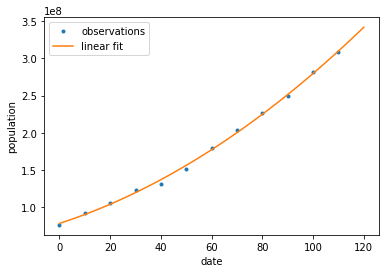

In [7]:
%matplotlib inline
plt.figure()
plt.plot(date,population,'.')
polyx = np.linspace(0,120,num=100)
polyy = x[0] + x[1]*polyx + x[2]*polyx*polyx

plt.plot(polyx,polyy)
plt.xlabel('date')
plt.ylabel('population')
plt.legend(('observations', 'linear fit'))

In [8]:
P2020 = x[0]+(2020-1900)*x[1]+x[2]*(2020-1900)**2
print(P2020)

342047136.3636383


In [9]:
def plot(degree, date, population):
    A = np.ones((12,degree+1))
    for i in range(1,degree+1):
        A[:,i] = date**i
    x = npla.lstsq(A, population, rcond = None)[0]
    P2020 = x[0]
    for i in range(1, degree+1):
        P2020+=x[i]*(2020-1900)**i
    print(P2020)
    %matplotlib inline
    plt.figure()
    plt.plot(date,population,'.')
    polyx = np.linspace(0,120,num=100)
    polyy = x[0]
    for i in range(1, degree+1):
        polyy+=x[i]*polyx**i
        
    plt.plot(polyx,polyy)
    plt.xlabel('date after 1900')
    plt.ylabel('population')
    plt.legend(('observations', 'linear fit'))

342047136.3636383


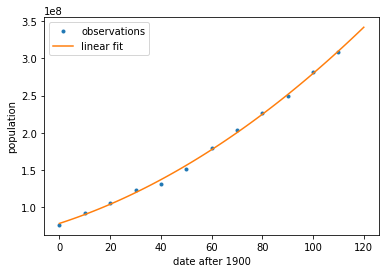

In [10]:
plot(2, date, population)

341124797.9795571


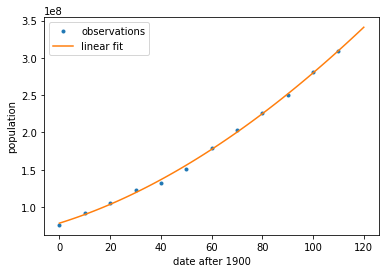

In [11]:
plot(3, date, population)

332065502.472789


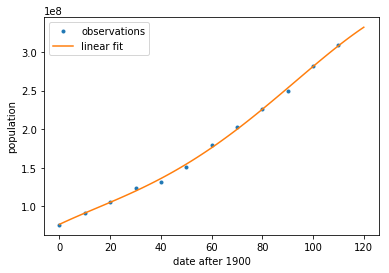

In [57]:
plot(4, date, population)

348063859.1336825


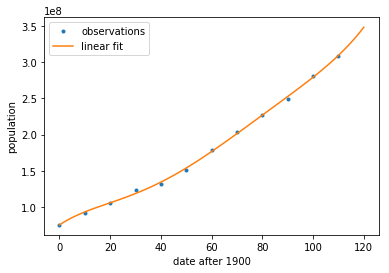

In [58]:
plot(5, date, population)

352746040.69666636


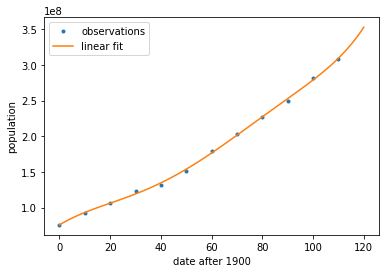

In [59]:
plot(6, date, population)

267999484.6031189


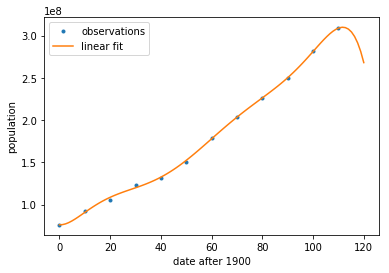

In [60]:
plot(7, date, population)

-544040423.7277832


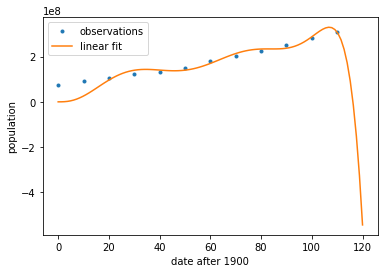

In [62]:
plot(8, date, population)

In [32]:
x = 1.0
for i in range(60):
    fprint(x)
    if 4.0 == (4.0+x): 
        fprint(x);
        print("reach")
        break
    x = x/2.

input     : 1.0
as float64: 1.0000000000000000e+00
as hex    : 3ff0000000000000
sign      : 0 means +
exponent  : 3ff means 1023 - 1023 = 0
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.5
as float64: 5.0000000000000000e-01
as hex    : 3fe0000000000000
sign      : 0 means +
exponent  : 3fe means 1022 - 1023 = -1
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.25
as float64: 2.5000000000000000e-01
as hex    : 3fd0000000000000
sign      : 0 means +
exponent  : 3fd means 1021 - 1023 = -2
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.125
as float64: 1.2500000000000000e-01
as hex    : 3fc0000000000000
sign      : 0 means +
exponent  : 3fc means 1020 - 1023 = -3
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.0625
as float64: 6.2500000000000000e-02
as hex    : 3fb0000000000000
sign      : 0 means +
exponent  : 3fb means 1019 - 1023 = -4
mantissa  : 1.0000

In [17]:
2**(-53)-10**(-16)

1.1022302462515656e-17

In [18]:
x=1/(2**(-53))

In [19]:
fprint(x)

input     : 9007199254740992.0
as float64: 9.0071992547409920e+15
as hex    : 4340000000000000
sign      : 0 means +
exponent  : 434 means 1076 - 1023 = 53
mantissa  : 1.0000000000000000000000000000000000000000000000000000



In [20]:
2**(1023)*(2-2**(-52))

1.7976931348623157e+308

In [21]:
x=2**(-53)

In [65]:
fprint(2**(-53))

input     : 1.1102230246251565e-16
as float64: 1.1102230246251565e-16
as hex    : 3ca0000000000000
sign      : 0 means +
exponent  : 3ca means 970 - 1023 = -53
mantissa  : 1.0000000000000000000000000000000000000000000000000000



In [29]:
fprint(1/64)

input     : 0.015625
as float64: 1.5625000000000000e-02
as hex    : 3f90000000000000
sign      : 0 means +
exponent  : 3f9 means 1017 - 1023 = -6
mantissa  : 1.0000000000000000000000000000000000000000000000000000



In [30]:
fprint(1/32)

input     : 0.03125
as float64: 3.1250000000000000e-02
as hex    : 3fa0000000000000
sign      : 0 means +
exponent  : 3fa means 1018 - 1023 = -5
mantissa  : 1.0000000000000000000000000000000000000000000000000000



In [35]:
2**(7)

128

In [39]:
2**15*(2-2**(-10))

65504.0

In [40]:
2**(127)*(2-2**(-7))

3.3895313892515355e+38

In [41]:
A = np.array([[1, 0],[0,1000]])
B = np.array([[1,0],[1,0]])

In [42]:
npla.cond(A)

1000.0

In [44]:
npla.cond(B)

inf

In [56]:
incre = 0
x = 1.0
while(x + x > x):
    incre+=1
    x = x / 2.0
    fprint(x)
print(incre)

input     : 0.5
as float64: 5.0000000000000000e-01
as hex    : 3fe0000000000000
sign      : 0 means +
exponent  : 3fe means 1022 - 1023 = -1
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.25
as float64: 2.5000000000000000e-01
as hex    : 3fd0000000000000
sign      : 0 means +
exponent  : 3fd means 1021 - 1023 = -2
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.125
as float64: 1.2500000000000000e-01
as hex    : 3fc0000000000000
sign      : 0 means +
exponent  : 3fc means 1020 - 1023 = -3
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.0625
as float64: 6.2500000000000000e-02
as hex    : 3fb0000000000000
sign      : 0 means +
exponent  : 3fb means 1019 - 1023 = -4
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.03125
as float64: 3.1250000000000000e-02
as hex    : 3fa0000000000000
sign      : 0 means +
exponent  : 3fa means 1018 - 1023 = -5
mantissa  : 1

mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 5.345529420184391e-51
as float64: 5.3455294201843913e-51
as hex    : 3580000000000000
sign      : 0 means +
exponent  : 358 means 856 - 1023 = -167
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 2.6727647100921956e-51
as float64: 2.6727647100921956e-51
as hex    : 3570000000000000
sign      : 0 means +
exponent  : 357 means 855 - 1023 = -168
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.3363823550460978e-51
as float64: 1.3363823550460978e-51
as hex    : 3560000000000000
sign      : 0 means +
exponent  : 356 means 854 - 1023 = -169
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 6.681911775230489e-52
as float64: 6.6819117752304891e-52
as hex    : 3550000000000000
sign      : 0 means +
exponent  : 355 means 853 - 1023 = -170
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 3.3409

exponent  : 2cf means 719 - 1023 = -304
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.5340917079055395e-92
as float64: 1.5340917079055395e-92
as hex    : 2ce0000000000000
sign      : 0 means +
exponent  : 2ce means 718 - 1023 = -305
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 7.670458539527698e-93
as float64: 7.6704585395276977e-93
as hex    : 2cd0000000000000
sign      : 0 means +
exponent  : 2cd means 717 - 1023 = -306
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 3.835229269763849e-93
as float64: 3.8352292697638489e-93
as hex    : 2cc0000000000000
sign      : 0 means +
exponent  : 2cc means 716 - 1023 = -307
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.9176146348819244e-93
as float64: 1.9176146348819244e-93
as hex    : 2cb0000000000000
sign      : 0 means +
exponent  : 2cb means 715 - 1023 = -308
mantissa  : 1.00000000000000000000000000000000

exponent  : 229 means 553 - 1023 = -470
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.6401064715739963e-142
as float64: 1.6401064715739963e-142
as hex    : 2280000000000000
sign      : 0 means +
exponent  : 228 means 552 - 1023 = -471
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 8.200532357869981e-143
as float64: 8.2005323578699814e-143
as hex    : 2270000000000000
sign      : 0 means +
exponent  : 227 means 551 - 1023 = -472
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 4.100266178934991e-143
as float64: 4.1002661789349907e-143
as hex    : 2260000000000000
sign      : 0 means +
exponent  : 226 means 550 - 1023 = -473
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 2.0501330894674953e-143
as float64: 2.0501330894674953e-143
as hex    : 2250000000000000
sign      : 0 means +
exponent  : 225 means 549 - 1023 = -474
mantissa  : 1.000000000000000000000000

exponent  : 176 means 374 - 1023 = -649
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 2.1404388173910186e-196
as float64: 2.1404388173910186e-196
as hex    : 1750000000000000
sign      : 0 means +
exponent  : 175 means 373 - 1023 = -650
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.0702194086955093e-196
as float64: 1.0702194086955093e-196
as hex    : 1740000000000000
sign      : 0 means +
exponent  : 174 means 372 - 1023 = -651
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 5.351097043477547e-197
as float64: 5.3510970434775465e-197
as hex    : 1730000000000000
sign      : 0 means +
exponent  : 173 means 371 - 1023 = -652
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 2.6755485217387732e-197
as float64: 2.6755485217387732e-197
as hex    : 1720000000000000
sign      : 0 means +
exponent  : 172 means 370 - 1023 = -653
mantissa  : 1.00000000000000000000000

mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 3.5755558345213674e-248
as float64: 3.5755558345213674e-248
as hex    : 0c90000000000000
sign      : 0 means +
exponent  : 0c9 means 201 - 1023 = -822
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.7877779172606837e-248
as float64: 1.7877779172606837e-248
as hex    : 0c80000000000000
sign      : 0 means +
exponent  : 0c8 means 200 - 1023 = -823
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 8.938889586303419e-249
as float64: 8.9388895863034186e-249
as hex    : 0c70000000000000
sign      : 0 means +
exponent  : 0c7 means 199 - 1023 = -824
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 4.4694447931517093e-249
as float64: 4.4694447931517093e-249
as hex    : 0c60000000000000
sign      : 0 means +
exponent  : 0c6 means 198 - 1023 = -825
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input    

as hex    : 01d0000000000000
sign      : 0 means +
exponent  : 01d means 29 - 1023 = -994
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 2.9864435792103004e-300
as float64: 2.9864435792103004e-300
as hex    : 01c0000000000000
sign      : 0 means +
exponent  : 01c means 28 - 1023 = -995
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 1.4932217896051502e-300
as float64: 1.4932217896051502e-300
as hex    : 01b0000000000000
sign      : 0 means +
exponent  : 01b means 27 - 1023 = -996
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 7.466108948025751e-301
as float64: 7.4661089480257510e-301
as hex    : 01a0000000000000
sign      : 0 means +
exponent  : 01a means 26 - 1023 = -997
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 3.7330544740128755e-301
as float64: 3.7330544740128755e-301
as hex    : 0190000000000000
sign      : 0 means +
exponent  : 019 means 25 - 102

In [54]:
fprint(8.98846567431158e+307)

input     : 8.98846567431158e+307
as float64: 8.9884656743115795e+307
as hex    : 7fe0000000000000
sign      : 0 means +
exponent  : 7fe means 2046 - 1023 = 1023
mantissa  : 1.0000000000000000000000000000000000000000000000000000



In [ ]:
A = np.round(np. random.rand(4,4))

In [5]:
fprint(970)

input     : 970
as float64: 9.7000000000000000e+02
as hex    : 408e500000000000
sign      : 0 means +
exponent  : 408 means 1032 - 1023 = 9
mantissa  : 1.1110010100000000000000000000000000000000000000000000

